In [11]:
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import cmcrameri
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.colors import Normalize
import sys
import pyreadr
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from evaluation.metrics import *
from utils import plot_cities, gev2frech, get_gev_params, f_madogram, frech2gev

In [12]:
plot_path = "../../plots/"

In [3]:
plt.style.use('seaborn-v0_8-whitegrid')
cmap_name = "cmc.roma_r"
cmap = plt.get_cmap(cmap_name)
plt.rcParams['image.cmap'] = cmap_name

In [4]:
ticksize = 20
fontsize = 28
axsize = 25
legendsize = 20
titlesize = 30
lw = 2.5

In [5]:
## Coordinates
lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)
lon2d, lat2d = np.meshgrid(lons, lats)

# Processed data

In [29]:
path = "../data/application/data/"
year = "2023"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

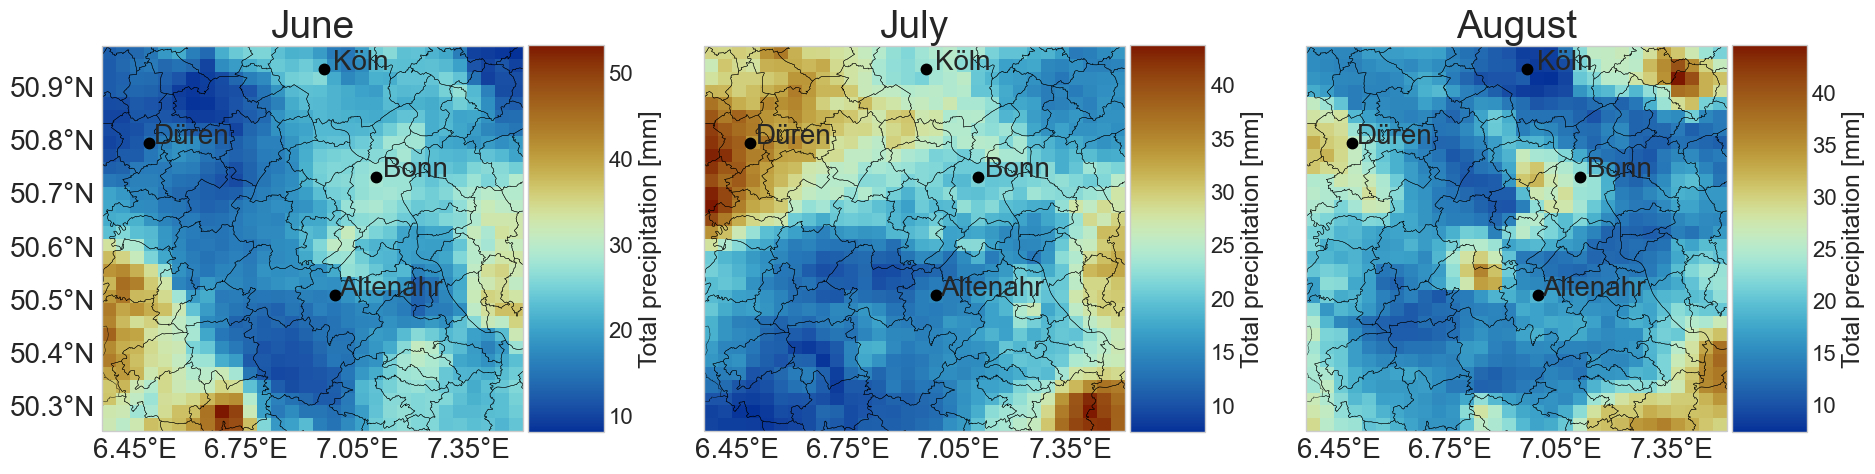

In [30]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data.isel(time = i))
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")



plt.savefig(plot_path + f"{year}_tp.png", bbox_inches = "tight")

# Analysis of Ahrtal

In [9]:
path = "../../data/application/"
lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)

data_prev = xr.open_dataset(path + "1931_2020_raw.nc").pr
data_prev = data_prev.isel(time = data_prev.time.dt.year >= 1980)
data_2021 = xr.open_dataset(path + "2021_raw.nc").pr
data_2022 = xr.open_dataset(path + "2022_raw.nc").pr
data_new = xr.concat([data_2021, data_2022], dim = "time")

In [9]:
# Old data
data_subset_prev = data_prev.where((data_prev.lon > lons[0]) & (data_prev.lon < lons[29]) & (data_prev.lat > lats[0]) & (data_prev.lat < lats[29]), drop = True).max(dim = ["x", "y"])

# New data
data_subset_new = data_new.where((data_new.lon > lons[0]) & (data_new.lon < lons[29]) & (data_new.lat > lats[0]) & (data_new.lat < lats[29]), drop = True).max(dim = ["x", "y"])

# Append
data_daily = xr.concat([data_subset_prev, data_subset_new], dim = "time")
data_monthly = data_daily.resample(time = "1MS").max()

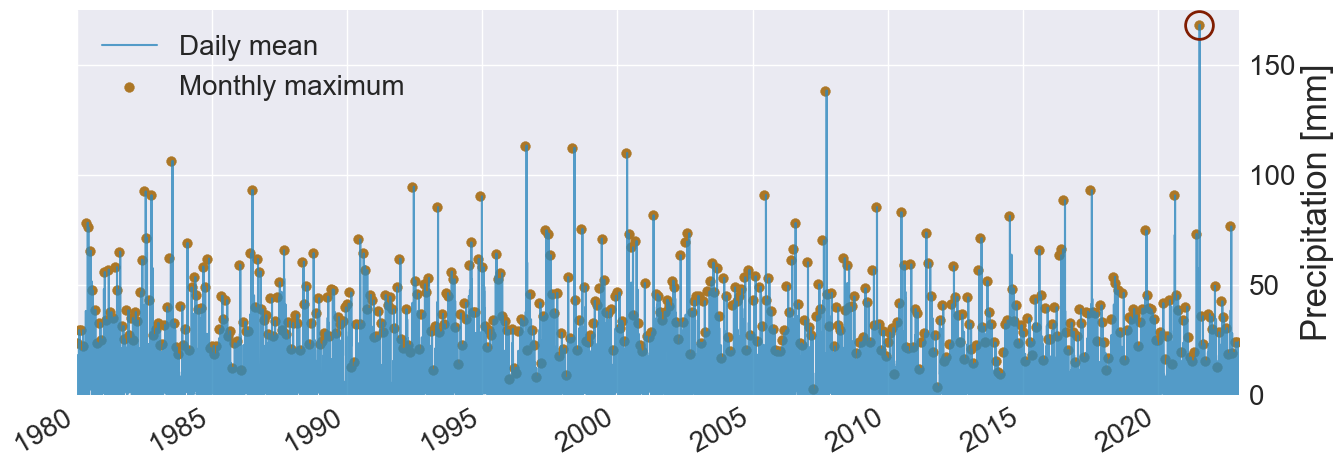

In [15]:
plt.style.use('seaborn-v0_8')
fig, axs = plt.subplots(figsize = (15,5))

data_daily.plot(color = cmap(0.2), lw = 1.5, alpha = 0.8, label = "Daily mean")
data_monthly.plot.scatter(color = cmap(0.8), label = "Monthly maximum", s = 50)

axs.set_xlabel(None)
axs.set_ylabel("Precipitation [mm]", fontsize = axsize)
axs.tick_params(axis='both', labelsize=ticksize)
axs.set_xlim([datetime.date(1980, 1, 1), datetime.date(2022, 12, 31)])
axs.set_ylim([0,175])
axs.legend(fontsize = legendsize)

# Add circle for July 2021
axs.plot(datetime.date(2021, 7, 1), 168, 'o',ms=10 * 2, mec=cmap(0.99), mfc='none', mew=2)

axs.yaxis.set_label_position("right")
axs.yaxis.tick_right()

plt.savefig(plot_path + f"precipitation_ts.pdf", bbox_inches = "tight")

# Data with Fréchet margins

In [17]:
path = "../data/application/data/"
year = "2023"
data = xr.open_dataset(path + f"{year}_month_max.nc").pr

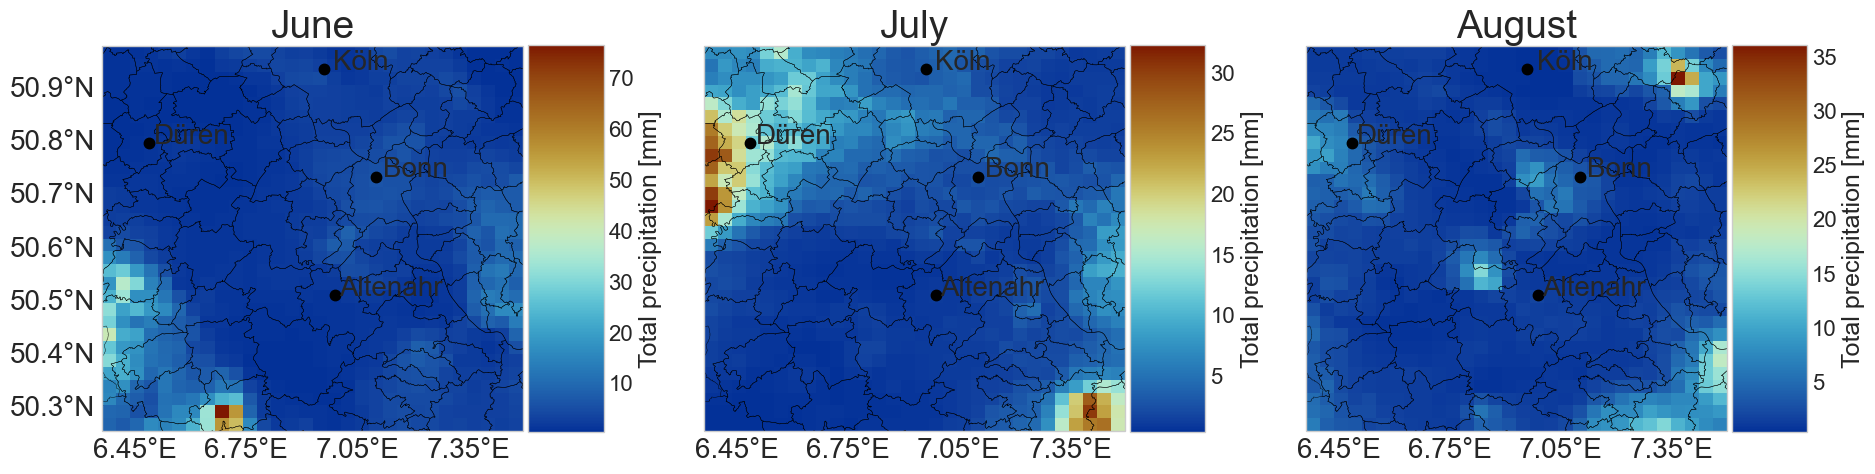

In [18]:
# Transformation
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "July", "August"]

for i in range(3):
    data_transformed = gev2frech(data.isel(time = i), year = 2022)
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data_transformed)
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")

plt.savefig(plot_path + f"{year}_frechet_tp.png", bbox_inches = "tight")


# GEV parameters

In [31]:
path = "../../data/application/"
gev_params = get_gev_params()
gev_2023 = gev_params["loc1"] + lon2d * gev_params["loc_lon"] + lat2d*gev_params["loc_lon"] + gev_params["loc_time"] * (2023-1931+1)

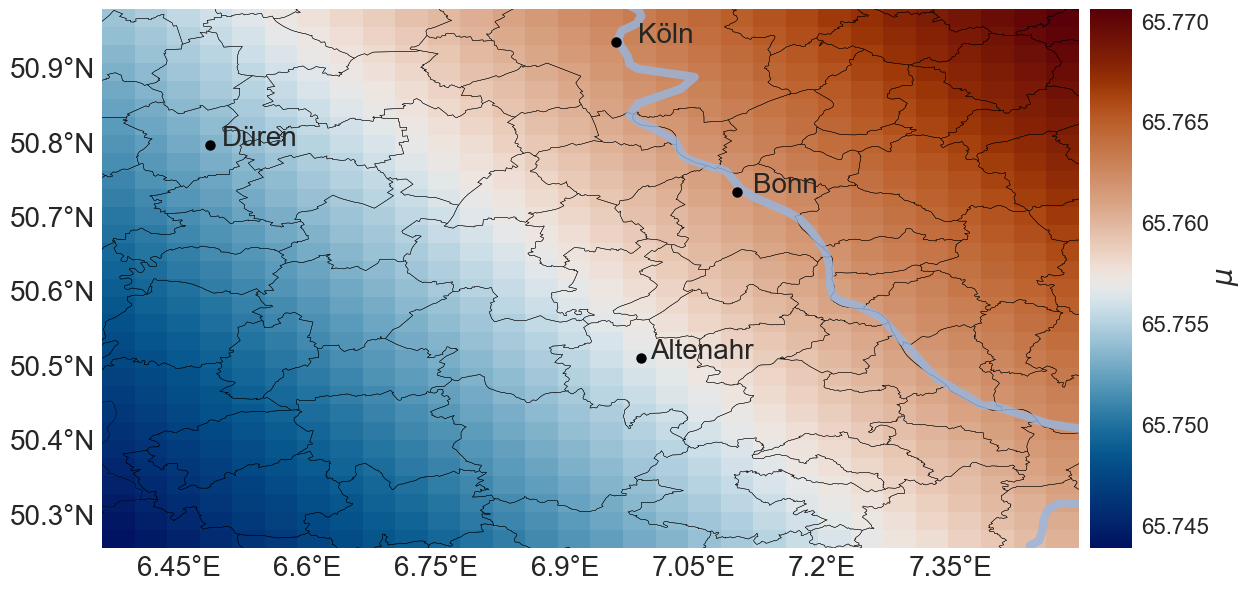

In [32]:
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(15,7))

ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                edgecolor='black', facecolor = "None", lw = 0.3)

pcm = axs.pcolormesh(lons, lats, gev_2023, cmap = "cmc.vik")
cb = fig.colorbar(pcm, ax=axs,  pad = 0.01, aspect = 13)
cb.ax.tick_params(labelsize=16)
cb.set_label(label=r" $\mu$",size=legendsize)
plot_cities(axs, river = True)

gl = axs.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': ticksize}
gl.ylabel_style = {'size': ticksize}
axs.set_aspect("auto")

plt.savefig(plot_path + f"gev_parameters.png", bbox_inches = "tight")

# Results

In [29]:
model = "brown"
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

In [30]:
plt.style.use('seaborn-v0_8')
colors = [cmap(x) for x in np.linspace(0.1,0.99,9)]
labels = ["June 2021", "July 2021", "August 2021", "June 2022", "July 2022", "August 2022", "June 2023", "July 2023", "August 2023"]

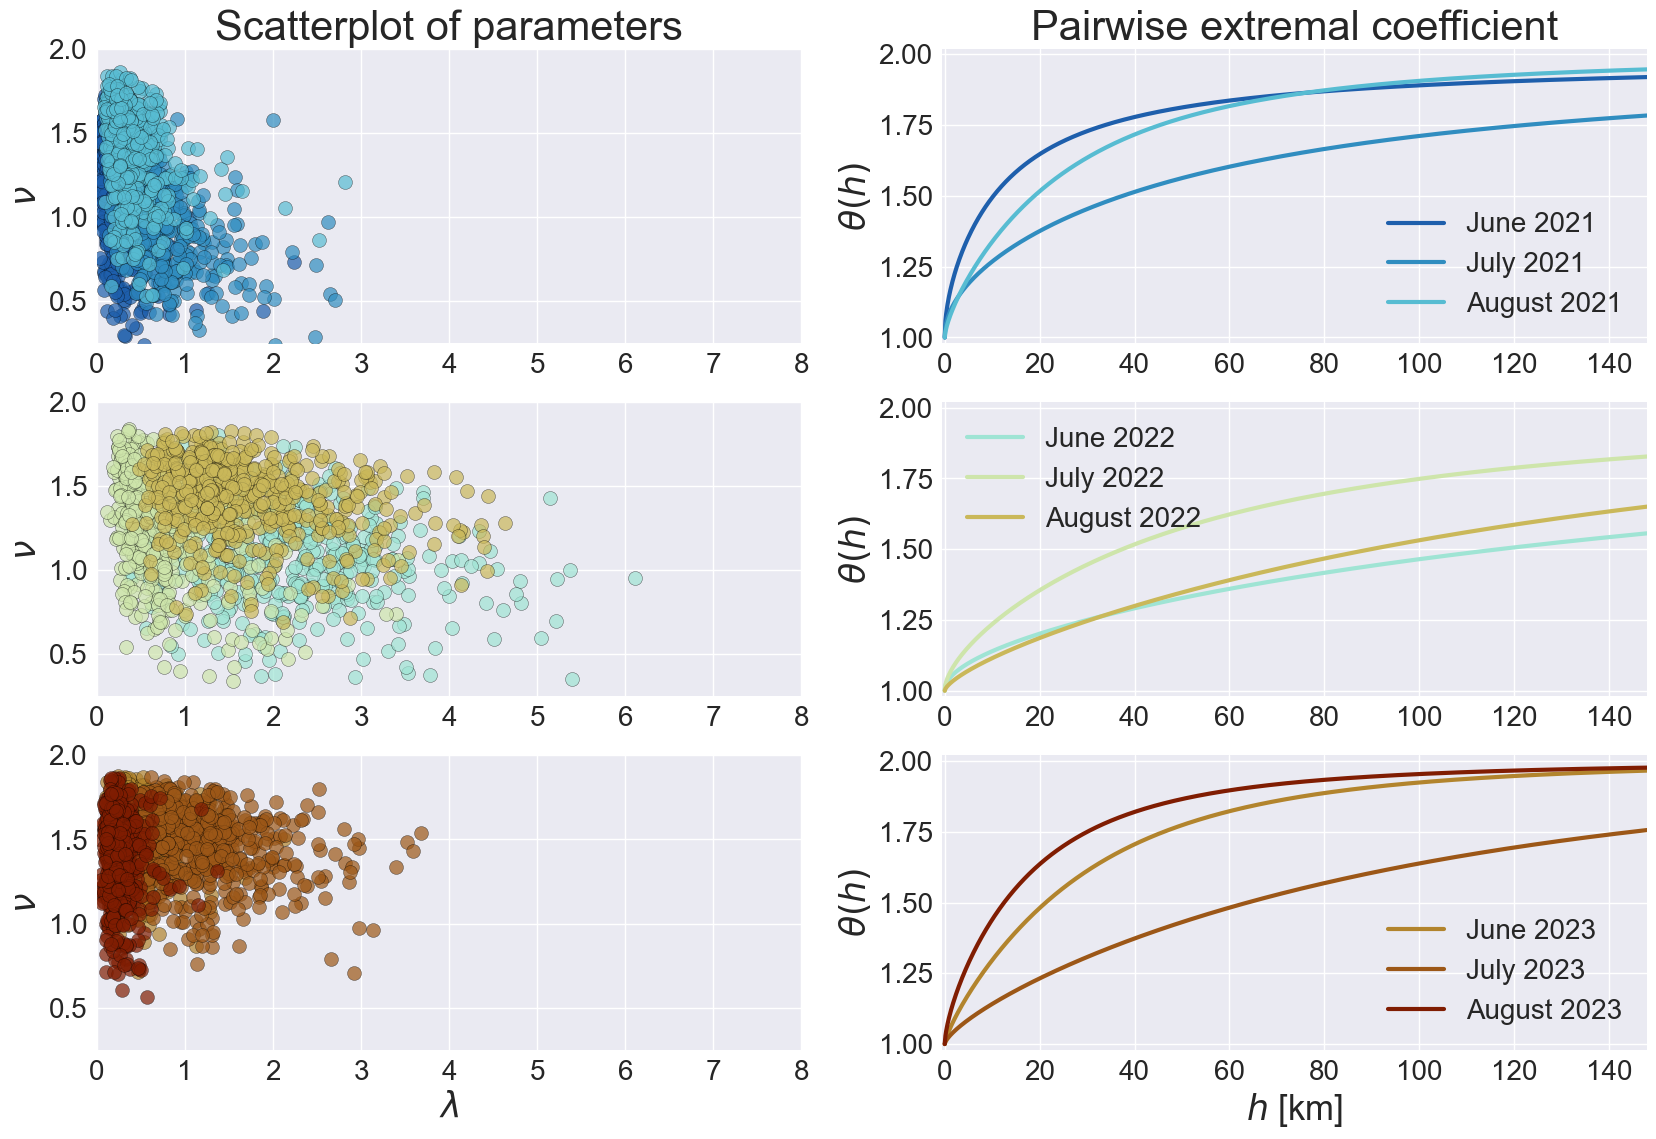

In [32]:
h = np.linspace(0,3.7,1000)
h_plot = h *40

fig, axs = plt.subplots(3,2, figsize = (20,13))

for j in range(3):
    for i in range((j*3), (j+1)*3):
        # Scatter plot
        axs[j,0].scatter(x = cnn_es[i,0], y = cnn_es[i,1], s = 100, edgecolor = "black", color = colors[i], label = labels[i], alpha = 0.7)
        axs[j,0].set_ylabel(r"$\nu$", fontsize = axsize)
        axs[j,0].tick_params(axis='both', labelsize=ticksize)
        axs[j,0].set_xlim([0,8])
        axs[j,0].set_ylim([0.25,2])
        #axs[j,0].legend(fontsize = legendsize)
        

        # Extremal coefficient
        axs[j,1].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[i,0], cnn_es[i,1]), lw = 3, label = labels[i], color = colors[i])
        axs[j,1].set_ylabel(r"$\theta(h)$", fontsize = axsize)
        axs[j,1].tick_params(axis='both', labelsize=ticksize)
        axs[j,1].legend(fontsize = legendsize)       
        axs[j,1].set_ylim([0.98,2.02])
        axs[j,1].set_xlim([-0.5,148])

axs[0,0].set_title("Scatterplot of parameters", fontsize = titlesize)
axs[0,1].set_title("Pairwise extremal coefficient", fontsize = titlesize)
axs[2,0].set_xlabel(r"$\lambda$", fontsize = axsize)
axs[2,1].set_xlabel(r"$h$ [km]", fontsize = axsize)

plt.savefig(plot_path + f"cnn_es_estimate_{model}.pdf", bbox_inches = "tight")

# F-Madogram

In [19]:
plt.style.use('seaborn-v0_8')
model = "brown"
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
pl = pyreadr.read_r(f"../data/application/results/{model}_pl.RData")["results"].to_numpy()[:,0:2]

In [20]:
path = "../data/application/data/"

# Load test data
data_prev = xr.open_dataset(path + "1931_2020_month_max.nc").isel(time = slice(240, 270))
for year in range(2011, 2021):
    data_prev.loc[dict(time = str(year))] = gev2frech(data_prev.loc[dict(time = str(year))], year = year)
data_2021 = gev2frech(xr.open_dataset(path + "2021_month_max.nc"), year = 2021)
data_2022 = gev2frech(xr.open_dataset(path + "2022_month_max.nc"), year = 2022)
data_2023 = gev2frech(xr.open_dataset(path + "2023_month_max.nc"), year = 2023)
data_full = xr.concat([data_prev, data_2021, data_2022, data_2023], dim = "time")
data_new = xr.concat([data_2021, data_2022, data_2023], dim = "time")
grid = xr.open_dataset("../../data/application/" + "grid.nc").grid.data

#Test
data_madogram_full = data_full.pr.data.reshape((data_full.time.shape[0], -1))
data_madogram_new = data_new.pr.data.reshape((data_new.time.shape[0], -1))

In [21]:
# 2021 - 2023
n_sim = int(900*899/2)
result = np.zeros(shape = (n_sim,2))
cnt = 0
for i in range(899):
    for j in range((i+1),900):
        h = np.sqrt(np.sum(np.power(grid[:,i] - grid[:,j],2)))
        vf = f_madogram(data_madogram_new[:,i:i+1], data_madogram_new[:,j:j+1])
        result[cnt,0] = h
        result[cnt,1] = (1 +2*vf)/(1-2*vf)
        cnt += 1

bins = np.linspace(0,3.7,1000)
ind = np.digitize(result[:,0], bins)
bin_means = np.array([result[ind == i,1].mean() for i in range(len(bins))])

C:\Users\chris\AppData\Local\Temp\ipykernel_4216\175537485.py:15: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([result[ind == i,1].mean() for i in range(len(bins))])
c:\Users\chris\anaconda3\envs\ma\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [22]:
# 2011 - 2023
n_sim = int(900*899/2)
result = np.zeros(shape = (n_sim,2))
cnt = 0
for i in range(899):
    for j in range((i+1),900):
        h = np.sqrt(np.sum(np.power(grid[:,i] - grid[:,j],2)))
        vf = f_madogram(data_madogram_full[:,i:i+1], data_madogram_full[:,j:j+1])
        result[cnt,0] = h
        result[cnt,1] = (1 +2*vf)/(1-2*vf)
        cnt += 1

bins = np.linspace(0,3.7,1000)
ind = np.digitize(result[:,0], bins)
bin_means_full = np.array([result[ind == i,1].mean() for i in range(len(bins))])

C:\Users\chris\AppData\Local\Temp\ipykernel_4216\3096802637.py:15: RuntimeWarning: Mean of empty slice.
  bin_means_full = np.array([result[ind == i,1].mean() for i in range(len(bins))])


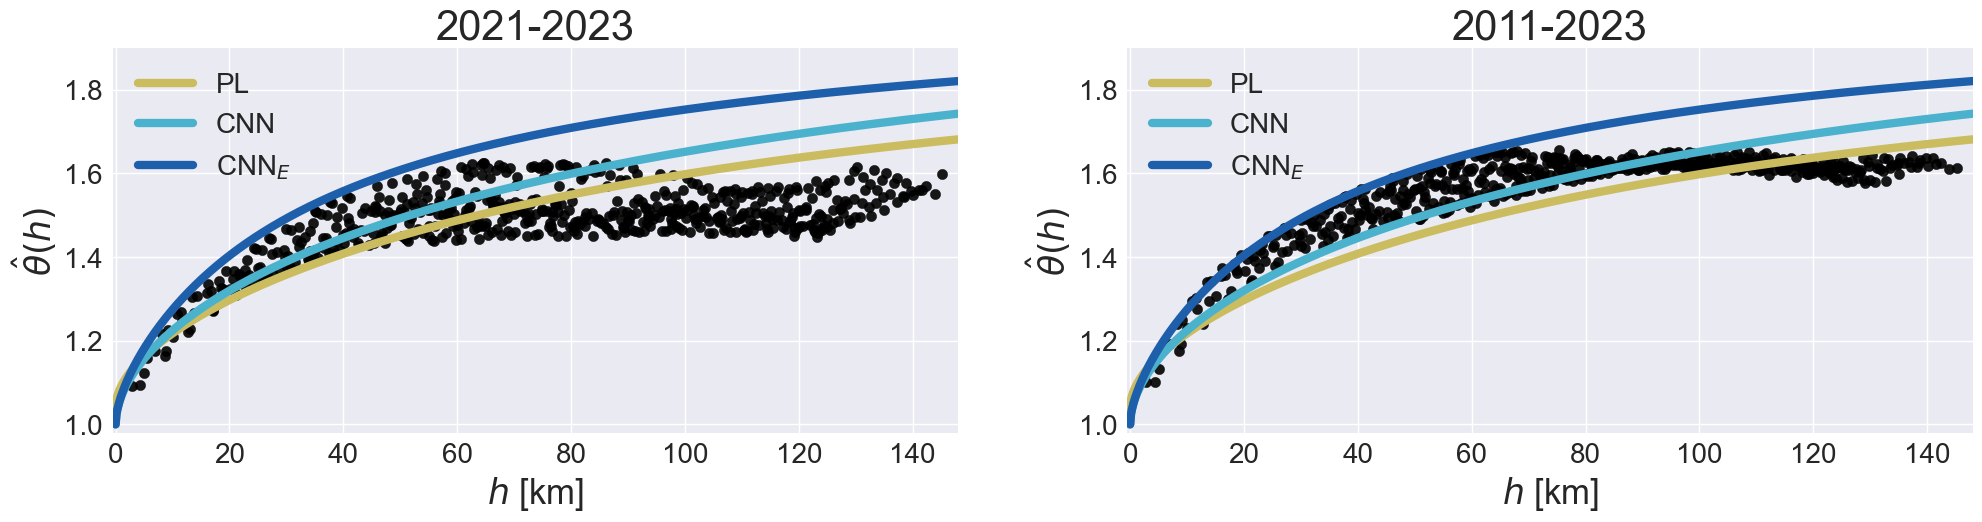

In [23]:
h = np.linspace(0,3.7,1000)
h_plot = h * 40
results = [bin_means, bin_means_full]
fig, axs = plt.subplots(1, 2, figsize = (24,5))
for i, bin in enumerate(results):
    axs[i].scatter(bins*40, bin, color = "black", s = 55, alpha = 0.9)

    axs[i].plot(h_plot, sample_extremal_coefficient(h, model, pl[:,0].flatten(), pl[:,1].flatten()), lw = 6, color = cmap(0.65), label = "PL")
    axs[i].plot(h_plot, sample_extremal_coefficient(h, model, cnn[:,0].flatten(), cnn[:,1].flatten()), lw = 6, color = cmap(0.3), label = "CNN")
    #CNN ES
    axs[i].plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[:,0].flatten(), cnn_es[:,1].flatten()), lw = 6, color = cmap(0.1), label = r"CNN$_E$")
    #quantiles = np.quantile(sample_extremal_coefficient(h, model, cnn_es[:,0].flatten(), cnn_es[:,1].flatten(),  mean = False), q = [0.025,0.975], axis = 0)

    #axs.plot(h_plot, quantiles[0], color = cmap(0.75), lw = 5, label = "95% prediction interval")
    #axs.plot(h_plot, quantiles[1], color = cmap(0.75), lw = 5)

    axs[i].set_ylim([0.98,1.9])
    axs[i].set_xlim([-0.5, 148])
    axs[i].tick_params(axis='both', labelsize=ticksize)
    axs[i].set_ylabel(r"$\hat{\theta}(h)$", fontsize = axsize)
    axs[i].set_xlabel(r"$h$ [km]", fontsize = axsize)
    axs[i].legend(fontsize = legendsize, loc = "best")

axs[0].set_title("2021-2023", fontsize = titlesize)
axs[1].set_title("2011-2023", fontsize = titlesize)

plt.savefig(plot_path + f"madogram_estimate_{model}.png", bbox_inches = "tight")

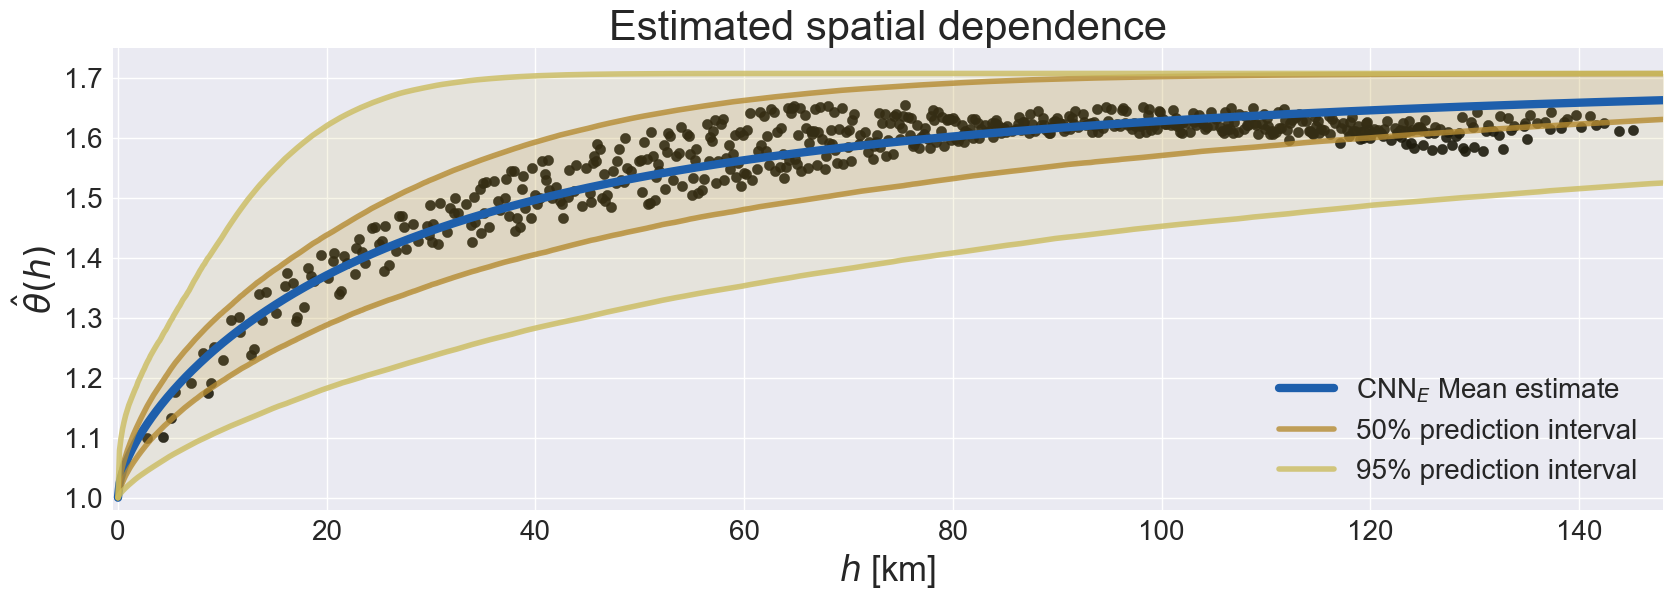

In [18]:
h = np.linspace(0,3.7,1000)
h_plot = h * 40
fig, axs = plt.subplots(figsize = (20,6))
axs.scatter(bins*40, bin_means_full, color = "black", s = 55, alpha = 0.9)

#CNN ES
axs.plot(h_plot, sample_extremal_coefficient(h, model, cnn_es[:,0].flatten(), cnn_es[:,1].flatten()), lw = 6, color = cmap(0.1), label = r"CNN$_E$ Mean estimate")
quantiles_1 = np.quantile(sample_extremal_coefficient(h, model, cnn_es[:,0].flatten(), cnn_es[:,1].flatten(),  mean = False), q = [0.025,0.975], axis = 0)
quantiles_2 = np.quantile(sample_extremal_coefficient(h, model, cnn_es[:,0].flatten(), cnn_es[:,1].flatten(),  mean = False), q = [0.25,0.75], axis = 0)

axs.plot(h_plot, quantiles_2[0], color = cmap(0.75), lw = 4, label = "50% prediction interval", alpha = 0.8)
axs.plot(h_plot, quantiles_2[1], color = cmap(0.75), lw = 4, alpha = 0.8)
axs.fill_between(h_plot, quantiles_2[0], quantiles_2[1], alpha=0.15, color = cmap(0.75))

axs.plot(h_plot, quantiles_1[0], color = cmap(0.65), lw = 4, label = "95% prediction interval", alpha = 0.8)
axs.plot(h_plot, quantiles_1[1], color = cmap(0.65), lw = 4, alpha = 0.8)
axs.fill_between(h_plot, quantiles_1[0], quantiles_1[1], alpha=0.15, color = cmap(0.65))

axs.set_ylim([0.98,1.75])
axs.set_xlim([-0.5, 148])
axs.tick_params(axis='both', labelsize=ticksize)
axs.set_ylabel(r"$\hat{\theta}(h)$", fontsize = axsize)
axs.set_xlabel(r"$h$ [km]", fontsize = axsize)
axs.legend(fontsize = legendsize, loc = "best")

axs.set_title("Estimated spatial dependence", fontsize = titlesize)

plt.savefig(plot_path + f"madogram_estimate_uncertainty.png", bbox_inches = "tight")

# Distance plot

In [12]:
model = "powexp"
cnn = np.load(f"../data/application/results/{model}_cnn.npy")
cnn_es = np.load(f"../data/application/results/{model}_cnn_es.npy")

path = "../../data/application/"
grid = xr.open_dataset(path + "grid.nc").grid.data

In [13]:
# Bonn in August 2023
point = 589
transformed_grid = np.sqrt(np.sum(np.power(grid - grid[:,point:(point+1)],2), axis = 0)).reshape((30,30))
i = 8
ext = sample_extremal_coefficient(transformed_grid, model, cnn_es[i,0], cnn_es[i,1])

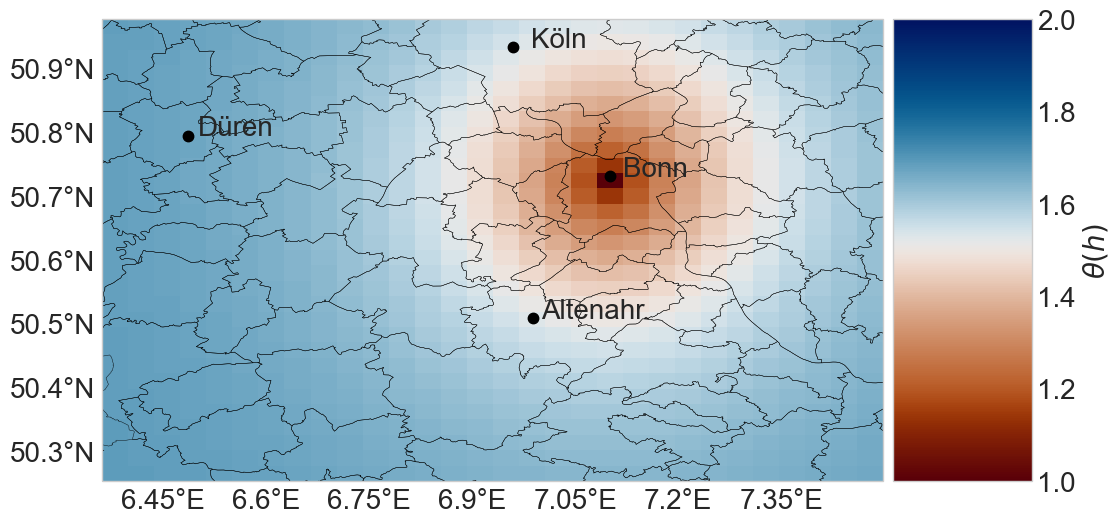

In [14]:
# Transformation
fig, axs = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()},figsize=(12,6))


ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
axs.add_geometries(ger_shape, ccrs.PlateCarree(),
                edgecolor='black', facecolor = "None", lw = 0.3)
pcm = axs.pcolormesh(lons, lats, ext, cmap = "cmc.vik_r", vmax = 2, vmin = 1)
cb = fig.colorbar(pcm, ax=axs,  pad = 0.01, shrink = 4, aspect = 3.31)
cb.set_label(label=r"$\theta(h)$",size=legendsize)
cb.ax.tick_params(labelsize=ticksize)
plot_cities(axs)
#axs.set_title(f"Extremal coefficient", fontsize = fontsize)
gl = axs.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False
gl.xlabel_style = {'size': ticksize}
gl.ylabel_style = {'size': ticksize}

axs.set_aspect("auto")
#axs.set_title("August 2023", fontsize = titlesize)

plt.savefig(plot_path + f"spatial_extremal_coefficient.png", bbox_inches = "tight")

# Process simulations

In [8]:
path = "../../data/application/"

lons = np.linspace(6.38,7.48,30)
lats = np.linspace(50.27,50.97,30)
lon2d, lat2d = np.meshgrid(lons, lats)

In [9]:
june = pyreadr.read_r(path+f"simulations_June2022.RData")["simulated_field"].to_numpy()
july = pyreadr.read_r(path+f"simulations_July2022.RData")["simulated_field"].to_numpy()
august = pyreadr.read_r(path+f"simulations_August2022.RData")["simulated_field"].to_numpy()

In [10]:
data = np.concatenate([np.reshape(june, (30,30,-1)), np.reshape(july, (30,30,-1)), np.reshape(august, (30,30,-1))], axis = 2)
data = data.reshape(30,30,10,3)

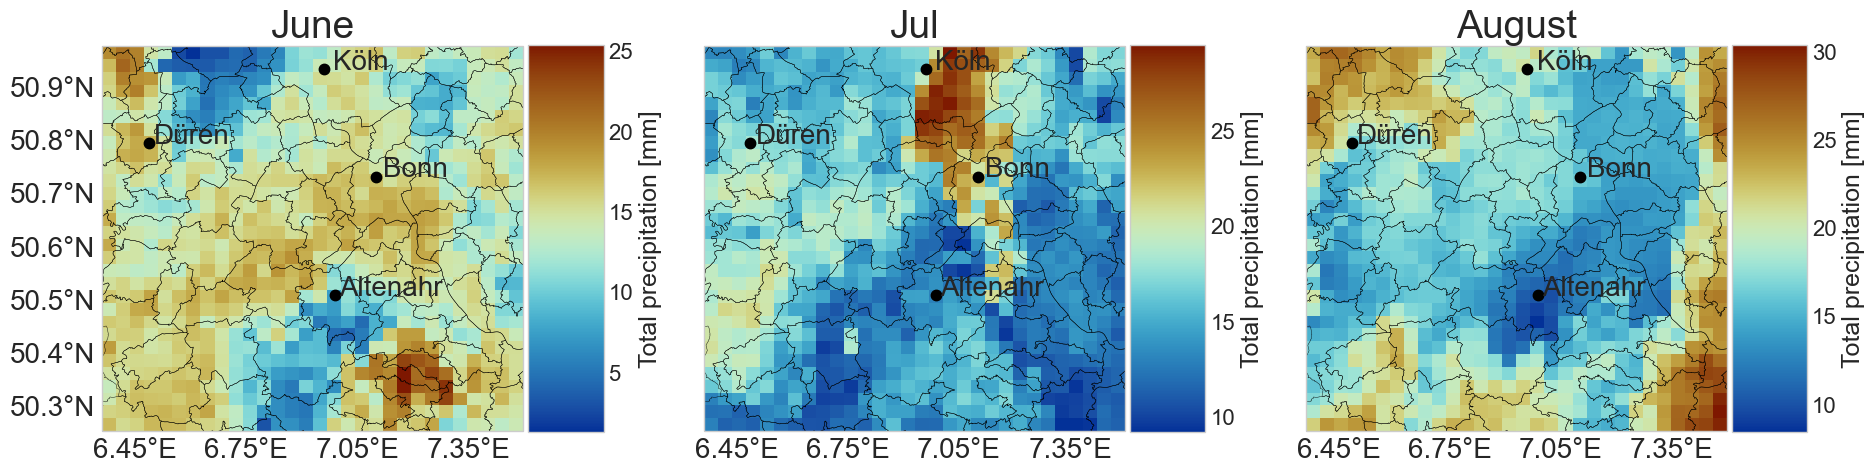

In [23]:
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()},figsize=(22,5))
months = ["June", "Jul", "August"]
samples = [4,4,9]
for i in range(3):
    data_transformed = frech2gev(data[:,:,samples[i],i], year = 2022)
    ger_shape = list(shpreader.Reader(path+"ger_shape/gadm41_DEU_3.shp").geometries())
    axs[i].add_geometries(ger_shape, ccrs.PlateCarree(),
                    edgecolor='black', facecolor = "None", lw = 0.3)
    pcm = axs[i].pcolormesh(lons, lats, data_transformed)
    cb = fig.colorbar(pcm, ax=axs[i],  pad = 0.01, shrink = 10, aspect = 5.14)
    cb.set_label(label="Total precipitation [mm]",size=18)
    cb.ax.tick_params(labelsize=16)
    plot_cities(axs[i])
    axs[i].set_title(f"{months[i]}", fontsize = fontsize)
    gl = axs[i].gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    if i > 0:
        gl.left_labels = False
    gl.xlabel_style = {'size': ticksize}
    gl.ylabel_style = {'size': ticksize}
    axs[i].set_aspect("auto")


plt.savefig(plot_path + "2022_tp_estimates.png", bbox_inches = "tight")